# Sound and Music Computing Summer School 2019
## Practice session on Optical Music Recognition

**Speaker**: Jorge Calvo-Zaragoza (jcalvo@dlsi.ua.es)



# Google Colaboratory

Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the (Google) cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.


## Getting started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that prints a greeting and a universal truth:


In [ ]:
print('Hello SMC,')
print('OMR is cool!')

Hello SMC,
OMR is cool!


We can also execute console commands by placing *!* at the beggining of the line:

In [ ]:
!/usr/bin/nvidia-smi

!python --version 

Sun May 26 12:28:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Keras

[Keras](https://keras.io/) is a high-level API for neural networks, obviously including deep learning (DL). Actually, it is main motivation. 

It is written in Python and runs over [TensorFlow](https://www.tensorflow.org/) (Google), [CNTK ](https://www.microsoft.com/en-us/cognitive-toolkit/) (Microsoft), [Theano](http://deeplearning.net/software/theano/) or [MxNet](https://mxnet.incubator.apache.org/) (Amazon) as backbone frameworks. It was primarily developed for research uses, with the aim of being able to move rapidly from an idea to preliminary results in the shortest possible time.

Essentially, Keras:

- allows fast prototyping because of its simplicity, modularity and extensibility.
- supports the most typical neural network elements (units, training algorithms, loss functions, etc.)
- runs over both CPU and GPU.

Most interesting charasteristics:

- **Ease of use**: Keras is an API designed for human beings. Keras follows best practices to reduce cognitive load: it offers consistent and simple APIs, minimizes the number of user actions required for common use cases, and provides clear and actionable feedback about user error.

- **Modularity**: A model is understood as a sequence or graphic of independent modules, totally configurable, that can be connected to each other with the minimum possible constraints. In particular, the neural layers, the cost functions, the optimizers, the initialization schemes, the activation functions and the regularization schemes are independent modules that can be combined to create new experiments.

- **Allows easy extension**: New modules are easy to add (like new classes and functions), and existing modules provide wide examples. Being able to easily create new modules allows total expressivity, making Keras suitable for advanced research.

- **Work with Python**: There are no separate configuration for neural models. The models are directly described in the Python code, which is compact and easy-to-debug.

# Step-by-step Optical Music Recognition system

Let's build a simple, yet complete, staff-based Optical Music Recognition (OMR) system.

The system will make use of deep neural networks, organized in an encoder-decoder topology based on Recurrent Neural Networks (RNN). Our encoder will also include a Convolutional Neural Network (CNN) to perform the feature extraction process during the encoding stage.

## Input domain

We need to define the input domain of our OMR system.

We choose an easy one:

* Printed
* Ideal conditions
* Modern notation
* Monophonic

We'll see that it is easy to extend this to other domains.

## Output domain

Sequence of **agnostic** symbols.

## Data

It is well known that Deep Learning models require training sets of sufficient size. The [Printed Images of Music Staves](https://grfia.dlsi.ua.es/primus/) (PrIMuS) dataset was devised to fulfill these requirements for end-to-end staff-based OMR research. Thus, the objective pursued when creating this ground-truth data was not to represent the most complex musical notation corpus, but collect the highest possible number of scores readily available to be represented in formats suitable for OMR experimentation and evaluation.

PrIMuS contains 87678 real-music incipits (an incipit is a sequence of notes, typically the first ones, used for identifying a melody or musical work), each one represented by five files: the Plaine and Easie code source, an image with the rendered score, the musical symbolic representation of the incipit both in Music Encoding Initiative format (MEI) and in an on-purpose simplified encoding (semantic encoding), and a sequence containing the graphical symbols shown in the score with their position in the staff without any musical meaning (agnostic encoding). 

A sample from PrIMuS:

![Sample image](https://github.com/calvozaragoza/tf-deep-omr/blob/master/Data/Example/000051652-1_2_1.png?raw=true)

whose *agnostic* representation sequence is as follows:

`clef.C-L1	accidental.flat-L4	accidental.flat-L2	accidental.flat-S3	digit.2-L4	digit.4-L2	digit.2-S5 digit.3-S5	multirest-L3	barline-L1	rest.quarter-L3	rest.eighth-L3	note.eighth-L4	barline-L1 note.quarter-L4	dot-S4	note.eighth-L3	barline-L1	note.quarter-S5	dot-S5	note.eighth-L5	barline-L1 note.eighth-S4	note.eighth-S4	rest.quarter-L3	barline-L1`

Due to efficiency reasons, we will just use a subset of PrIMuS for this tutorial. We will build our training set of pairs (image, agnostic representation) to train our deep encoder-decoder architecture. 


## Model overview 

Our DL model will consist of:

* Encoder CNN: the input image is first fed into a CNN that learns a feature representation that is useful for the task at hand.
* Encoder RNN: the last filtered image of the CNN is used as input to the encoder RNN, that processes the image frame by frame to produce a latent representation of the whole input staff region
* Decoder RNN: from the latent vector, the decoder RNN will predict a symbol step by step. The last predicted symbol is fed into the decoder in the next step. The first symbol provided to the encoder is that of *start of sentence* (SOS). The process is stopped once the decoder RNN predicts an *end of sentence* (EOS) symbol.

A graphical overview of the considered architecture is shown in the following figure:

![Topology](https://drive.google.com/uc?id=14EVEPy-zedcPBYyavefiAeeBcpG6J0HZ)

## Preliminary: generators

In the case of tasks solved with RNNs, and especially with the encoder-decoder approach, it is usual to have variable-length inputs and outputs sequences. Although, by definition, RNNs can handle sequences of variable size, internally Keras (likewise other frameworks) works with fixed-dimension data batches for a more efficient processing.


To alleviate this problem, there are two alternatives: to create as many batches as sequences are (which is inefficient in training) or to use the *padding* technique. Padding consists in calculating the longest sequence and establishing the dimensions according to this value. Shorter sequences are filled with null values (typically 0). The problem is that, when the differences between the lengths are very high, padding becomes very severe and causes a less effective learning.


However, there is an intermediate, elegant, solution to deal with this issue: mini batches. That is, to build small batches and apply intra-batch padding. To be able to do this in Keras, it is necessary to use *generator* functions. Generators are Python functions that prepare such batches. On each call, the generator prepares the next batch to be considered and *freezes*, until it is called in again to generate another batch. Generator functions allow us to return batches that contain a fixed number of elements. Then we can do padding at the batch level, thereby reducing the aforementioned problem.


The following code provides an intuitive example of this behavior (pay special attention to keywords **yield** and **next**).

In [ ]:
import numpy as np    # Python's Matrix package

sample = [[1,2], [3,4,5], [6,7,8,9], [10]]

def example_generator(data, batch_size):  
    while True:
      for idx in range(0,len(data),batch_size):
        batch = data[idx:idx+batch_size]                
        max_length = max([len(b) for b in batch])        
        fixed_dim_batch = np.zeros((len(batch),max_length), dtype=np.int)
        
        for i,b in enumerate(batch):
          fixed_dim_batch[i,:len(b)] = b
          
        yield fixed_dim_batch
                          
generator = example_generator(sample, batch_size = 2)

print('Batch',1)
x  = next(generator)
print(x)
print(x.shape)
print()
print('Batch',2)
x  = next(generator)
print(x)
print(x.shape)

Batch 1
[[1 2 0]
 [3 4 5]]
(2, 3)

Batch 2
[[ 6  7  8  9]
 [10  0  0  0]]
(2, 4)


### Bucketting

Another concept (which will not appear in the implementation below) is *bucketting*. This strategy first orders the dataset so that elements within the same batch are of similar length. This minimizes intra-batch padding, thus approaching the optimal (but inefficient) way of performing the training process element by element.

In [ ]:
import numpy as np    # Python's Matrix package

sample = [[1,2], [3,4,5], [6,7,8,9], [10]]

def bucketting_generator(data, batch_size):
    data.sort(key = len)
    while True:
      for idx in range(0,len(data),batch_size):
        batch = data[idx:idx+batch_size]                
        max_length = max([len(b) for b in batch])        
        fixed_dim_batch = np.zeros((len(batch),max_length), dtype=np.int)
        
        for i,b in enumerate(batch):
          fixed_dim_batch[i,:len(b)] = b
          
        yield fixed_dim_batch
                          
generator = bucketting_generator(sample, batch_size = 2)

print('Batch',1)
x  = next(generator)
print(x)
print(x.shape)
print()
print('Batch',2)
x  = next(generator)
print(x)
print(x.shape)

Batch 1
[[10  0]
 [ 1  2]]
(2, 2)

Batch 2
[[3 4 5 0]
 [6 7 8 9]]
(2, 4)


# Code

## Data loading and preprocessing

In [ ]:
"""
Initialization of Google Drive file system
"""

import zipfile
from google.colab import drive
import glob

drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Cursos/SMC Summer School 2019/PriMuS-40000.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

data_folder = '/tmp/PriMuS-40000'
num_samples = len(glob.glob(data_folder+'/*.png'))

print('Num. samples:',num_samples)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num. samples: 40000


In [ ]:
"""

Data loading:

Each sample consists of a pair (x,y) such that:
 - x: single-staff image (*.png)
 - y: sequence of symbols (*.txt)
 
"""

import cv2     # OpenCV image package
import tqdm    # Loop with loading bar

X = []
Y = []

num_samples = 20000 # Tune according to resources

# Loop over each image file
for idx in tqdm.tqdm(range(1,num_samples+1)):
  image = cv2.imread(data_folder+'/'+str(idx)+'.png', False) # Grayscale
  
  sequence_file = open(data_folder+'/'+str(idx)+'.txt', "r")
  sequence = sequence_file.readline().split()
  sequence_file.close()
  
  X.append(image)
  Y.append(sequence)

100%|██████████| 20000/20000 [00:29<00:00, 689.01it/s]


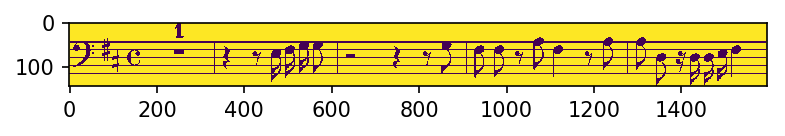

['clef.F-L4', 'accidental.sharp-L4', 'accidental.sharp-S2', 'metersign.C-L3', 'digit.1-S5', 'multirest-L3', 'barline-L1', 'rest.quarter-L3', 'rest.eighth-L3', 'note.sixteenth-S3', 'note.sixteenth-L4', 'note.sixteenth-S4', 'note.eighth-S4', 'barline-L1', 'rest.half-L3', 'rest.quarter-L3', 'rest.eighth-L3', 'note.eighth-S4', 'barline-L1', 'note.eighth-L4', 'note.eighth-L4', 'rest.eighth-L3', 'note.eighth-L5', 'note.quarter-L4', 'rest.eighth-L3', 'note.eighth-L5', 'barline-L1', 'note.eighth-L5', 'note.eighth-L3', 'rest.sixteenth-L3', 'note.sixteenth-L3', 'note.sixteenth-L3', 'note.sixteenth-S3', 'note.quarter-L4']


In [ ]:
"""
Visualization of data loading
"""

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 150

idx_example = 5

# Display first two samples
f = plt.figure()
f.add_subplot(1,1,1)
plt.imshow(X[idx_example])
plt.show(block=True)

print(Y[idx_example])


In [ ]:
"""
The network needs a fixed height (i.e., features per frame).
The width is variable, and so we rescale to a fixed height
but keeping the aspect ratio.
"""

def resize(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    return cv2.resize(image, (width, height))

img_height = 64
for idx,image in enumerate(X):
  X[idx] = resize(image,img_height)

In [ ]:
"""
We need the special characters 'start of sequence' (sos) and
'end of sequence' (eos)
""" 
output_sos = '<s>'
output_eos = '</s>'

# We include both to the ground-truth sequence
Y = [ [ output_sos ] +  sequence + [ output_eos ] for sequence in Y]

# We can then compute the set of symbols
alphabet = set()

for sequence in Y:
    alphabet.update(sequence)
              
alphabet_len = len(alphabet)    

print('There is a total of ' + str(alphabet_len) + ' symbols: ' + str(sorted(alphabet)))

# Building conversors from symbol to int and inversely
alphabet_from_char_to_int = dict([(char, i) for i, char in enumerate(alphabet)])
alphabet_from_int_to_char = dict([(i, char) for i, char in enumerate(alphabet)])

There is a total of 706 symbols: ['</s>', '<s>', 'accidental.flat-L-1', 'accidental.flat-L0', 'accidental.flat-L1', 'accidental.flat-L2', 'accidental.flat-L3', 'accidental.flat-L4', 'accidental.flat-L5', 'accidental.flat-L6', 'accidental.flat-L7', 'accidental.flat-L8', 'accidental.flat-S-1', 'accidental.flat-S-2', 'accidental.flat-S0', 'accidental.flat-S1', 'accidental.flat-S2', 'accidental.flat-S3', 'accidental.flat-S4', 'accidental.flat-S5', 'accidental.flat-S6', 'accidental.flat-S7', 'accidental.natural-L-1', 'accidental.natural-L-2', 'accidental.natural-L0', 'accidental.natural-L1', 'accidental.natural-L2', 'accidental.natural-L3', 'accidental.natural-L4', 'accidental.natural-L5', 'accidental.natural-L6', 'accidental.natural-L7', 'accidental.natural-L8', 'accidental.natural-S-1', 'accidental.natural-S-2', 'accidental.natural-S-3', 'accidental.natural-S0', 'accidental.natural-S1', 'accidental.natural-S2', 'accidental.natural-S3', 'accidental.natural-S4', 'accidental.natural-S5', 'ac

## Evaluation

How can we measure how well an OMR system recognizes an input score? Unfortunately, this is a **long-standing unresolved question** in the field. 

However, in this context we only need a measure of how well the network is learning. The *loss* function value could be used but it is difficult to interpret. That is why we are going to use the **edit distance**.

Given that our output domain consists of sequences of music symbols, we can *evaluate* the learning process as regards the edit distance between the ground-truth sequence and the sequence predicted by the model. 

The edit distance between *A* and *B* counts the number of editing operations (insert, delete, or replace) needed to convert a sequence *A* into the sequence *B*. Note that in our context this can be seen as the cost of correcting the output of the OMR system.

In [ ]:
# Evaluation

def edit_distance(a,b):
    "Computes the Levenshtein distance between sequence a and b."
    n, m = len(a), len(b)

    if n > m:
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]
  
example_A = ['clef.F-L4', 'rest.quarter-L3', 'note.quarter-S3', 'barline-L1']
example_B = ['clef.F-L4', 'rest.quarter-L1', 'note.quarter-S3', 'note.eighth-S2', 'barline-L1']

print('Edit distance: ', edit_distance(example_A, example_B))

Edit distance:  2


## Training


We now must define the generators (see above) for the training set, taking into account that:
* The encoder receives an image
* The decoder receives a sequence of symbols (starting with SOS)
* The decoder emits a sequence of symbols (ending with EOS)

In [ ]:
"""
We build a generator for getting batches of equal width size.
"""

import numpy as np # Python's Matrix package

def vector_to_batch(X_batch, Y_batch):
    max_batch_image_len = max([image.shape[1] for image in X_batch])

    encoder_input = np.zeros((len(X_batch),img_height,max_batch_image_len), dtype=np.float)

    for idx, image in enumerate(X_batch):
        encoder_input[idx][:,:image.shape[1]] = image  

    encoder_input = np.expand_dims(encoder_input, axis=-1) # Tensor-wise input (B,H,W) -> (B,H,W,1)
    encoder_input = (255. - encoder_input) / 255. # Image normalization within [0,1]
    
    max_batch_output_len = max([len(sequence) for sequence in Y_batch])

    decoder_input = np.zeros((len(Y_batch),max_batch_output_len,alphabet_len), dtype=np.float)
    decoder_output = np.zeros((len(Y_batch),max_batch_output_len,alphabet_len), dtype=np.float)

    for idx_s, output_sentence in enumerate(Y_batch):        
        for idx_c, char in enumerate(output_sentence):
            decoder_input[idx_s][idx_c][alphabet_from_char_to_int[char]] = 1.
            if idx_c > 0:
                decoder_output[idx_s][idx_c-1][alphabet_from_char_to_int[char]] = 1.
                
    return encoder_input, decoder_input, decoder_output

def generator(X, Y, batch_size):
  idx = 0
  while True:
    X_batch = X[idx:idx+batch_size]
    Y_batch = Y[idx:idx+batch_size]
    
    encoder_input, decoder_input, decoder_output = vector_to_batch(X_batch, Y_batch)
    
    yield [encoder_input, decoder_input], decoder_output
    
    idx = (idx + batch_size) % len(X)

In [ ]:
sanity_check_generator = generator(X,Y, batch_size = 16)

[encoder_input, decoder_input], decoder_output = next(sanity_check_generator)

print ('Encoder input: ' + str(encoder_input.shape))
print ('Decoder input: ' + str(decoder_input.shape))
print ('Decoder output: ' + str(decoder_output.shape))

Encoder input: (16, 64, 699, 1)
Decoder input: (16, 36, 706)
Decoder output: (16, 36, 706)


## Model definition

We must select the specific hyper-parameters of our CNN-Encoder-Decoder. The example below sets the network as:
* CNN with 4 layers
* RNN-Encoder with one layer
* RNN-Decoder with one layer

In [ ]:
from keras.layers import Input, Dense, Flatten, Reshape, Permute
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras import backend as K

def getmodel(img_height, alphabet_len):
  filters = [32, 64, 128, 128]
  w_pooling = [2,2,2,2]
  h_pooling = [2,2,2,2]

  if K.image_data_format() == 'channels_last':
    input_data = Input(name='input', shape=(img_height, None, 1))
  else:
    input_data = Input(name='input', shape=(1, img_height, None))


  # Encoder-CNN with 4 layers    
  inner = Conv2D(filters[0], (3, 3), padding='same', activation='relu')(input_data)
  inner = BatchNormalization()(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[0], w_pooling[0]))(inner)

  inner = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(inner)
  inner = BatchNormalization()(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[1], w_pooling[1]))(inner)

  inner = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(inner)
  inner = BatchNormalization()(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[2], w_pooling[2]))(inner)

  inner = Conv2D(filters[3], (3, 3), padding='same', activation='relu')(inner)
  inner = BatchNormalization()(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[3], w_pooling[3]))(inner)
  
  # Reshaping to input the Encoder-RNN
  permute = Permute((2,1,3))(inner) #     
  w_factor = np.prod(np.array(w_pooling))
  h_factor = np.prod(np.array(h_pooling))

  # This goes as a function of the number of poolings
  conv_to_rnn_dims = (-1, (img_height // (h_factor)) * filters[3])        
  encoder_input = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(permute)    

  # Encoder-RNN
  encoder_outputs, state_h, state_c = LSTM(512, return_state=True)(encoder_input)
  encoder_states = [state_h, state_c]

  # Decoder-RNN
  decoder_inputs = Input(shape=(None, alphabet_len))
  decoder_outputs, _, _ = LSTM(512, return_sequences=True, return_state=True)(decoder_inputs, initial_state=encoder_states)
  decoder_dense = Dense(alphabet_len, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  # We create the single model with two inputs 
  model = Model([input_data, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy')   
  model.summary()

  return model

  
model = getmodel(encoder_input.shape[1],alphabet_len)  

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, None, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, None, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, None, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, None, 32) 0           batch_normalization_1[0][0]      
_____________________________________

Data splitting into training and validation

In [ ]:
val_split = 0.1 # 10 % of the data will be used to validate the learning process
idx_split = int(len(X)*val_split)

X_train = X[idx_split:]
Y_train = Y[idx_split:]

X_val = X[:idx_split]
Y_val = Y[:idx_split]


Training loop

In [ ]:
import math # Inf

TR_BATCH_SIZE = 32
train_generator = generator(X_train, Y_train, batch_size = TR_BATCH_SIZE)
x_val, y_val, t_val = vector_to_batch(X_val, Y_val)

# We monitor the edit distance over the validation set every two epochs
MINI_EPOCH = 2
previous_val_ed = math.inf

# Loop over epochs
for epoch in range(30):
  print()
  print('-----> Epoch', epoch*MINI_EPOCH)
  
  # Run the training process for some epochs
  history = model.fit_generator(train_generator, 
                   steps_per_epoch=len(X_train)//TR_BATCH_SIZE, 
                   verbose=2, 
                   epochs=MINI_EPOCH, 
                   validation_data=[[x_val,y_val],t_val])  
  
  
  """
  Monitorization over the validation set
  """
  current_val_ed = 0
  
  # Prediction over the validation set
  batch_prediction = model.predict([x_val,y_val],batch_size=16)
  
  # Loop over all validation samples
  for idx,sentence_prediction in enumerate(batch_prediction):  

      # Compute the ground-truth sequence
      raw_gt_sequence = [alphabet_from_int_to_char[char] for char in np.argmax(t_val[idx],axis=1)] 
      gt_sequence = []          
      
      for char in raw_gt_sequence:
        gt_sequence += [char]
        if char == output_eos:
            break
      
      # Compute the predicted sequence      
      raw_predicted_sequence = [alphabet_from_int_to_char[char] for char in np.argmax(sentence_prediction,axis=1)] 
      predicted_sentence = []          
      
      for char in raw_predicted_sequence:
        predicted_sentence += [char]
        if char == output_eos:
            break
            
      # Accumulate the edit distance
      current_val_ed += edit_distance(gt_sequence,predicted_sentence)
  
  # Compute the average edit distance
  current_val_ed = (1. * current_val_ed) / len(x_val)
  
  # Show validation results
  print()
  print()
  print('Epoch ' + str(((epoch+1)*MINI_EPOCH)-1) + ' - Validation edit dist.: ' + str(current_val_ed))  
  print()
  print()
  
  
  # To automatize the training and avoid overfitting, uncomment the following lines
  '''
  if current_val_ed > previous_val_ed:
    break;
  else:
    previous_val_ed = current_val_ed
  '''    



-----> Epoch 0
Epoch 1/2
 - 238s - loss: 0.9285 - val_loss: 0.7601
Epoch 2/2
 - 237s - loss: 0.8548 - val_loss: 0.7459


Epoch 1 - Validation edit dist.: 11.0585



-----> Epoch 2
Epoch 1/2
 - 238s - loss: 0.7830 - val_loss: 0.7077
Epoch 2/2
 - 237s - loss: 0.7211 - val_loss: 0.7065


Epoch 3 - Validation edit dist.: 10.4135



-----> Epoch 4
Epoch 1/2
 - 238s - loss: 0.6663 - val_loss: 0.6883
Epoch 2/2
 - 237s - loss: 0.6164 - val_loss: 0.7155


Epoch 5 - Validation edit dist.: 10.299



-----> Epoch 6
Epoch 1/2
 - 238s - loss: 0.5711 - val_loss: 0.6829
Epoch 2/2
 - 237s - loss: 0.5293 - val_loss: 0.6783


Epoch 7 - Validation edit dist.: 9.6995



-----> Epoch 8
Epoch 1/2
 - 238s - loss: 0.4905 - val_loss: 0.6879
Epoch 2/2
 - 237s - loss: 0.4558 - val_loss: 0.6769


Epoch 9 - Validation edit dist.: 9.646



-----> Epoch 10
Epoch 1/2
 - 238s - loss: 0.4250 - val_loss: 0.6970
Epoch 2/2
 - 238s - loss: 0.3961 - val_loss: 0.7015


Epoch 11 - Validation edit dist.: 9.598



-----> Epoch 

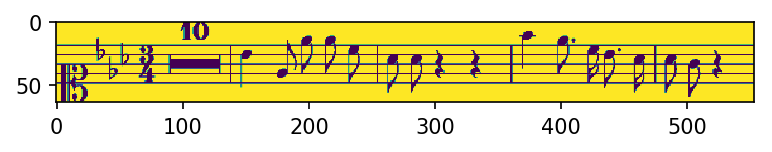

Hypothesis:
	 clef.C-L1
	 accidental.flat-L4
	 accidental.flat-L2
	 accidental.flat-S3
	 digit.3-L4
	 digit.4-L2
	 digit.1-S5
	 digit.1-S5
	 multirest-L3
	 barline-L1
	 note.quarter-L4
	 dot-S4
	 dot-S2
	 barline-L1
	 barline-L1
	 barline-L1
	 note.eighth-S3
	 note.eighth-L4
	 rest.quarter-L3
	 rest.quarter-L3
	 barline-L1
	 digit.1-S5
	 dot-S6
	 note.eighth-L5
	 note.eighth-S4
	 note.eighth-L4
	 barline-L1
	 note.eighth-S3
	 barline-L1
	 note.eighth-S3
	 note.eighth-L3
	 rest.quarter-L3
	 rest.quarter-L3
	 barline-L1


In [ ]:
"""
Example of prediction after the model is trained
"""

idx_eval = 1 # Id of the validation sample to test

# Batch preparation
sample_x, sample_y, _ = vector_to_batch([X_val[idx_eval]], [Y_val[idx_eval]])

# Prediction and conversion to symbols
batch_prediction = model.predict([sample_x, sample_y])
predicted_sequence = [alphabet_from_int_to_char[char] for char in np.argmax(batch_prediction[0],axis=1)]

# Plot score
f = plt.figure()
f.add_subplot(1,1,1)
plt.imshow(X_val[idx_eval])
plt.show(block=True)

# Display hypothesis
print('Hypothesis:')
for symbol in predicted_sequence:
  if symbol == output_eos:
    break
  
  print('\t',symbol)

## Exercises

### Initialize your environment

* Repeat the experiment in your own Google Colab
  - The dataset is available [here](https://drive.google.com/file/d/1KOcLA-EBOSgbktFv3gzu1lsCPsy1AJ02/view?usp=sharing).

### Basic
* Hyper-parameter tuning for improving performance (both efficiency and effectiveness)
* Implement *bucketting* 
 
### Medium
* Error analysis: errors per symbol, errors per length of the image, errors per length of the output sequence
* Make the RNNs bidirectional

### Advanced
* Convert the output to MIDI
* Modifications for double output (glyph, position)  
* Real prediction (the decoder input is unknown) 
* Add an attention model: [tutorial](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html)

